# P. White-box adversarial attack

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def get_output(x, w, klass=None, normalize=False, truncate=False):
    if normalize:
        x = x * 0.01 - 1.28
    if truncate:
        x = (x + 1.28) * 100
        x = x.astype('uint8')
        x = x * 0.01 - 1.28
    if klass is not None:
        return softmax(w @ x)[klass]
    else:
        return softmax(w @ x)

In [3]:
w = np.loadtxt('input/p_model.tsv')
images = np.loadtxt('input/p_test.tsv')
images, classes = images[:, :-1], images[:, -1]
original_images = images
classes = classes.astype(int)
images = images * 0.01 - 1.28

Let's look at our images and targets.

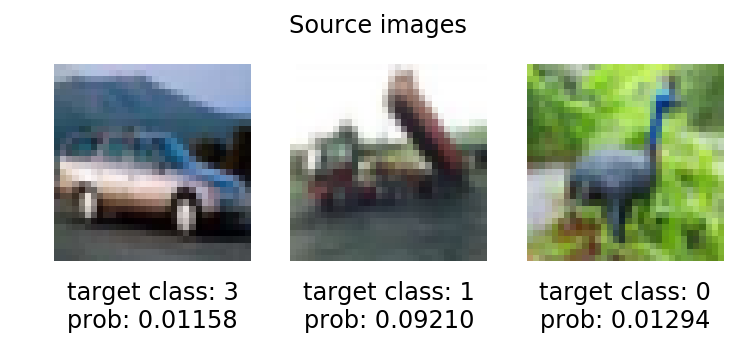

In [4]:
for i in range(3):
    plt.subplot(131 + i)
    plt.imshow(original_images[i].reshape(32, 32, -1).astype('B'))
    plt.axis('off')
    plt.title(f'target class: {classes[i]}\nprob: {get_output(original_images[i], w, classes[i], True):.5f}', 
              y=-0.4)
plt.suptitle('Source images', y=0.76);

The idea is to start with source image and incrementally update it a little bit in opposite gradient direction, so that each time our model outputs higher and higher probability that the image belongs to the target class. 

In [5]:
l2_reg = 0.063
num_iter = 100000
lr = 0.01
target_images = []
for n in range(3):
    x = images[n].copy()
    original = x.copy()
    target = np.zeros(10)
    target[classes[n]] = 1
    for i in range(num_iter):
        output = get_output(x, w)
        gradient = w.T @ (output - target)
        gradient += l2_reg * (x - original)
        x -= lr * gradient
        x = x.clip(-1.28, 1.27)
        p = get_output(x, w, classes[n], False, True)
        if p > 0.5:
            target_images.append(((x + 1.28) * 100).astype('uint8'))
            break
            
target_images = np.array(target_images)

Let's look at resulting images:

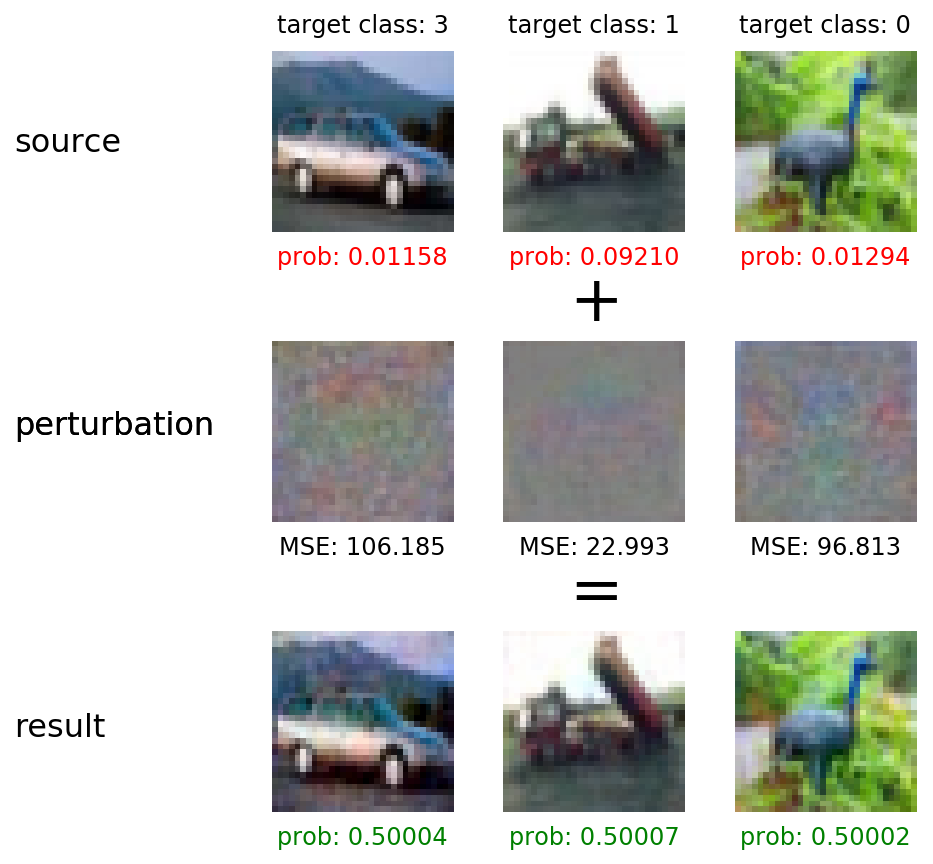

In [6]:
plt.figure(figsize=(7, 7))

for i in range(3):
    ax = plt.subplot(331 + i)
    plt.imshow(original_images[i].reshape(32, 32, -1).astype('uint8'))
    plt.axis('off')
    plt.text(0.5, 1.1, f'target class: {classes[i]}', 
             fontsize=12, horizontalalignment='center', transform=ax.transAxes)
    plt.text(0.5, -0.18, f'prob: {get_output(original_images[i], w, classes[i], True):.5f}', 
             fontsize=12, horizontalalignment='center', fontdict={'color': 'r'}, transform=ax.transAxes)

for i in range(3):
    ax = plt.subplot(334 + i)
    plt.imshow((target_images[i] - original_images[i] + 128).reshape(32, 32, -1).astype('uint8'))
    plt.axis('off')
    plt.text(0.5, -0.18, f'MSE: {((target_images[i] - original_images[i]) ** 2).mean():.3f}', 
             fontsize=12, horizontalalignment='center', transform=ax.transAxes)

for i in range(3):
    ax = plt.subplot(337 + i)
    plt.imshow(target_images[i].reshape(32, 32, -1).astype('uint8'))
    plt.axis('off')
    plt.text(0.5, -0.18, f'prob: {get_output(target_images[i], w, classes[i], True):.5f}', 
             fontsize=12, horizontalalignment='center', fontdict={'color': 'g'}, transform=ax.transAxes)

plt.subplots_adjust(left=0.25, hspace=0.6)
plt.figtext(0.55, .613, '+', fontsize=32)
plt.figtext(0.55, .325, '=', fontsize=32)
plt.figtext(0, .78, 'source', fontsize=16)
plt.figtext(0, .5, 'perturbation', fontsize=16)
plt.figtext(0, .5, 'perturbation', fontsize=16)
plt.figtext(0, .2, 'result', fontsize=16);

Average MSE for 3 images:

In [7]:
((target_images - original_images) ** 2).mean()

75.330403645833329

It is greater than 70, so we wouldn't get maximum points for this task 😟

In [8]:
np.savetxt('output/p.out', target_images, '%d')